In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.preprocessing
from dask import dataframe as dd
from sklearn_pandas import DataFrameMapper

In [2]:
def process_raw_file():
    print('Processing CSV for use...')
    print('Reading CSV...')
    #df = ddf.read_csv('anime.csv').compute()
    df = pd.read_csv('original_data/anime.csv', index_col='mal_id', parse_dates=[7,8])

    # Which columns contain lists of elements
    LISTS = ['genres', 'themes', 'demographics', 'studios', 'producers', 
             'licensors']

    print('Filtering DataFrame...')
    # Drop entries that haven't finished airing or aren't approved yet
    df.drop(df.loc[df['status'] != 'Finished Airing'].index, inplace=True)
    df.drop(df.loc[df['pending_approval'] == 'TRUE'].index, inplace=True)
    # Drop entries that nobody has scored
    df.dropna(subset=['scored_by'], inplace=True)

    print('Evaluating lists...')
    # Turn list strings into actual lists
    for col in LISTS:
        df[col] = df[col].apply(eval)

    mapper = DataFrameMapper([
        #('mal_id', None),  NOTE: Used as the DataFrame index column
        ('title', None),
        ('type', None),
        ('score', None),
        ('scored_by', None),
        #('status', None),
        ('episodes', None),
        ('aired_from', None),  # TODO: Convert to datetime? 9 null
        #('aired_to', None),  NOTE: ~49% null
        ('source', None),
        ('members', None),
        ('favorites', None),
        ('duration', None),  # TODO: Convert to minutes or something? 13 null
        ('rating', None),
        ('nsfw', None),
        #('pending_approval', None),
        #('premiered_season', None),  NOTE: Redundant with aired_from, often null
        #('premiered_year', None),  NOTE: Redundant with aired_from, often null
        ('broadcast_day', None),
        #('broadcast_time', None),  NOTE: ~82% null
        ('genres', sklearn.preprocessing.MultiLabelBinarizer()),
        ('themes', sklearn.preprocessing.MultiLabelBinarizer()),
        ('demographics', sklearn.preprocessing.MultiLabelBinarizer()),
        ('studios', sklearn.preprocessing.MultiLabelBinarizer()),
        ('producers', sklearn.preprocessing.MultiLabelBinarizer()),
        ('licensors', sklearn.preprocessing.MultiLabelBinarizer()),
        ('synopsis', None),  # NOTE: 366 (2.6%) null
        #('background', None),  NOTE: ~88% null
        #('main_picture', None),
        #('url', None),
        #('trailer_url', None),
        #('title_english', None),
        #('title_japanese', None),
        #('title_synonyms', None),
    ], df_out=True)

    print('Transforming DataFrame...')
    mapped_df = mapper.fit_transform(df)

    print('Writing CSV...')
    ddf.from_pandas(mapped_df, npartitions=1).to_csv('mappedanime.csv', 
                                              single_file=True)
    #mapped_df.to_csv('mappedanime.csv')
    print("Done!")

    return mapped_df


if os.path.isfile('mappedanime.csv'):
    print('Reading CSV...')
    df = pd.read_csv('mappedanime.csv', 
                     index_col='mal_id', 
                     parse_dates=[6],
                     dtype={'mal_id': 'int64',
                            'title': 'object',
                            'type': 'category',
                            'score': 'float64',
                            'scored_by': 'int64',
                            'episodes': 'int64',
                            'aired_from': 'object',
                            'source': 'category',
                            'members': 'int64',
                            'favorites': 'int64',
                            'duration': 'object',
                            'rating': 'category',
                            'nsfw': 'category',
                            'broadcast_day': 'category',
                            'synopsis': 'object',
                            })
    print('Done!')
else:
    df = process_raw_file()

Reading CSV...
Done!


<Axes: xlabel='aired_from', ylabel='score'>

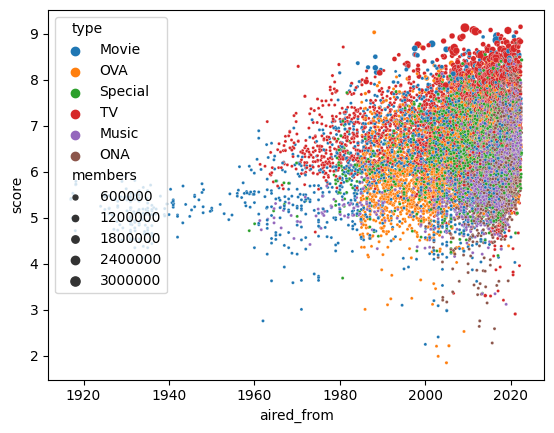

In [26]:
sns.scatterplot(data=df, x='aired_from', y='score', size='members', hue='type', sizes=(5,50))

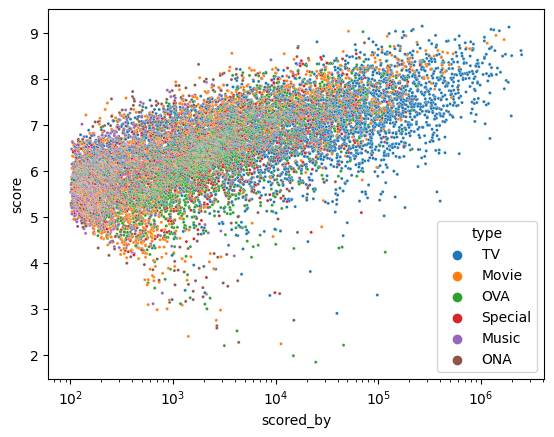

In [37]:
sns.scatterplot(data=df, x='scored_by', y='score', hue='type', s=5)
plt.xscale('log')

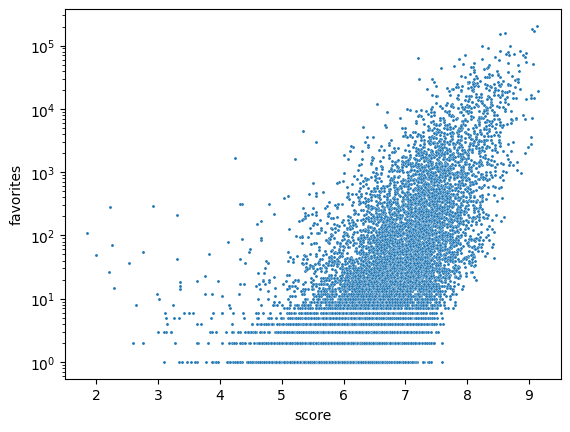

In [42]:
sns.scatterplot(data=df, x='score', y='favorites', s=5)
plt.yscale('log')

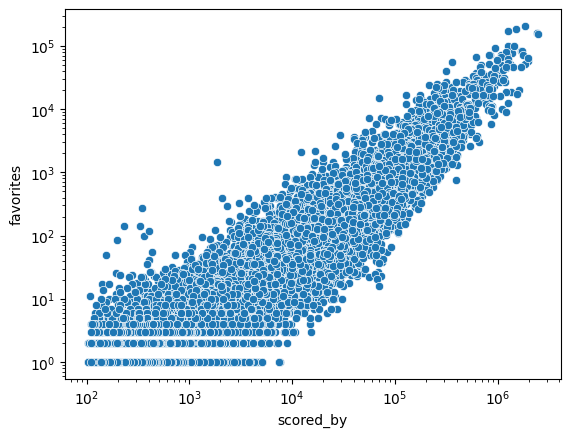

In [41]:
sns.scatterplot(data=df, x='scored_by', y='favorites')
plt.xscale('log')
plt.yscale('log')

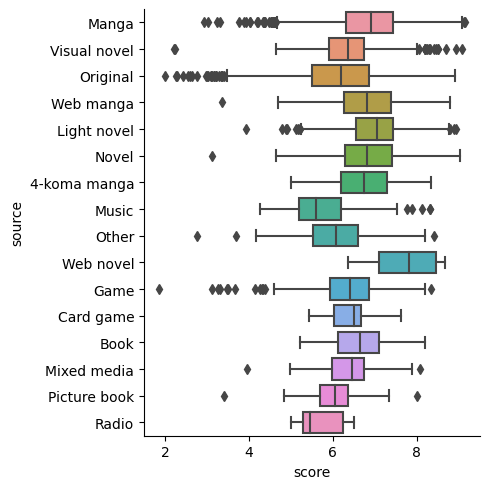

In [45]:
sns.catplot(data=df, x='score', y='source', kind='box')

In [19]:
phiks = df2.phik_matrix(interval_cols=['score', 'scored_by', 'episodes', 'aired_from', 'members', 'favorites'])
phiks.to_csv('phiks.csv')

KeyboardInterrupt: 

In [20]:
import xml.etree.ElementTree as ET

tree = ET.parse('animelist_2023_07_10.xml')
root = tree.getroot()

combined_df = df
combined_df['my_score'] = np.nan

for anime in root.findall('anime'):
    mal_id = int(anime.find('series_animedb_id').text)
    status = anime.find('my_status').text
    my_score = int(anime.find('my_score').text)
    if status == 'Completed' and my_score > 0:
        combined_df.loc[combined_df.index == mal_id, 'my_score'] = my_score

In [23]:
scored_df = combined_df.dropna(subset='my_score')
scored_df.to_csv('scored.csv')

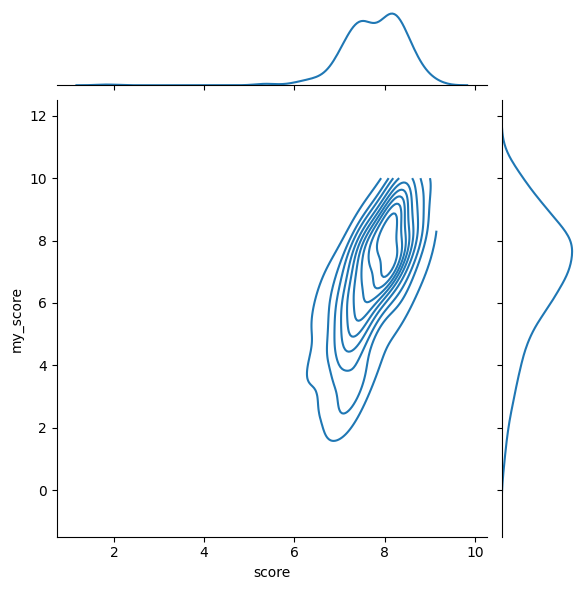

In [52]:
sns.jointplot(data=scored_df, x='score', y='my_score', kind='kde', cut=0)

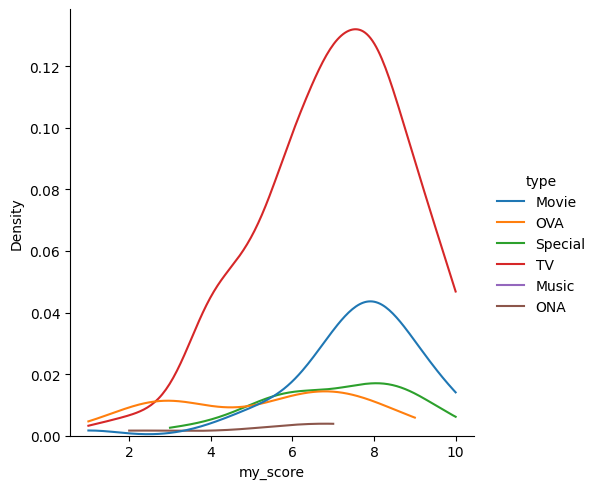

In [53]:
sns.displot(data=scored_df, x='my_score', hue='type', kind='kde', cut=0)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
transformed = vectorizer.fit_transform(df['synopsis'])

type: np.nan is an invalid document, expected byte or unicode string.

In [25]:
vectorizer.inverse_transform(transformed)

[array(['rewrite', 'mal', 'written', 'point', 'breaking', 'pushed',
        'principles', 'morality', 'unraveled', 'past', 'agonizing', 'trio',
        'suffering', 'bring', 'summoned', 'assassins', 'legendary',
        'group', 'situations', 'evolve', 'misadventures', 'soon', 'public',
        'impact', 'minimize', 'attempt', 'thompson', 'milly', 'stryfe',
        'meryl', 'agents', 'insurance', 'followed', 'gunsmoke', 'planet',
        'wasteland', 'traverses', 'tow', 'attitude', 'buffoonish',
        'obsession', 'doughnut', 'crazy', 'costs', 'violence', 'avoids',
        'life', 'taken', 'claims', 'softie', 'huge', 'actuality', 'say',
        'rumors', 'contact', 'eye', 'make', 'dead', 'count', 'goes',
        'destruction', 'death', 'trail', 'leaves', 'typhoon', 'humanoid',
        'title', 'garnering', 'fun', 'cities', 'entire', 'flattens',
        'oppose', 'waste', 'lays', 'villain', 'merciless', 'reason',
        'head', 'bounty', '000', '60', 'man', 'stampede', 'vash'],
     

In [4]:
dsk_df = dd.read_csv('original_data/anime.csv',  
                     parse_dates=['aired_from', 'aired_to'],
                     dtype={'mal_id': 'int64',
                            'title': 'object',
                            'type': 'category',
                            'score': 'float64',
                            'scored_by': 'float64',
                            'status': 'category',
                            'episodes': 'float64',
                            'aired_from': 'object',
                            'aired_to': 'object',
                            'source': 'category',
                            'members': 'float64',
                            'favorites': 'float64',
                            'duration': 'object',
                            'rating': 'category',
                            'nsfw': 'category',
                            'pending_approval': 'object',
                            'premiered_season': 'category',
                            'premiered_year': 'float64',
                            'broadcast_day': 'category',
                            'broadcast_time': 'object',
                            'genres': 'object',
                            'themes': 'object',
                            'demographics': 'object',
                            'studios': 'object',
                            'producers': 'object',
                            'licensors': 'object',
                            'synopsis': 'object',
                            'background': 'object',
                            'main_picture': 'object',
                            'url': 'object',
                            'trailer_url': 'object',
                            'title_english': 'object',
                            'title_japanese': 'object',
                            'title_synonyms': 'object',
                            }).set_index('mal_id')

In [9]:
df = dd.read_parquet('./animedata').compute()
df_old = dd.read_parquet('./animedata_v1').compute()

In [16]:
df_good = df.mask(df['score'] > 7)

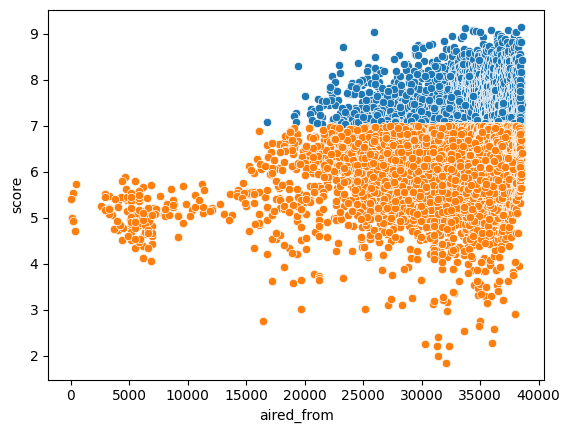

In [15]:
x = 'aired_from'
y= 'score'
log = False
sns.scatterplot(data=df, x=x, y=y)
if log: plt.xscale('log')
sns.scatterplot(data=df_good, x=x, y=y)
if log: plt.xscale('log')

In [28]:
df_good['studios_Wit Studio'].corr(df_good['score'], method='spearman')

-0.0004466071790779855

In [30]:
corrs_spearman = df_good.corr(method='spearman')

C:\Users\sibula\AppData\Local\Temp\ipykernel_4012\2334837041.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs_spearman = df_good.corr(method='spearman')


In [35]:
dd.from_pandas(corrs_spearman, npartitions=1).to_parquet('./corrs_spearman/')

<Axes: >

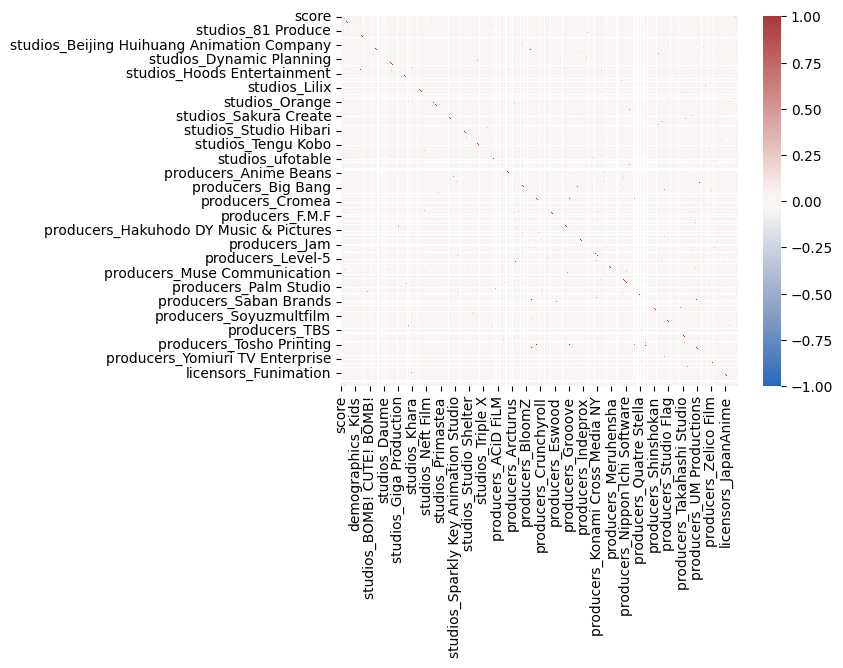

In [39]:
sns.heatmap(data=corrs_spearman, vmin=-1, vmax=1, cmap='vlag')

In [58]:
threshold = 0.05
corrs_spearman_sig = corrs_spearman.where((corrs_spearman < -threshold)
                                           | (corrs_spearman > threshold))
corrs_spearman_sig = corrs_spearman_sig.dropna(how='all')

In [79]:
var = 'genres_Award Winning'
print(corrs_spearman_sig[var].dropna().sort_values(ascending=False).head(10))
print()
print(corrs_spearman_sig[var].dropna().sort_values(ascending=False).tail(10))

genres_Award Winning          1.000000
producers_Geidai Animation    0.106162
Name: genres_Award Winning, dtype: float64

genres_Award Winning          1.000000
producers_Geidai Animation    0.106162
Name: genres_Award Winning, dtype: float64


In [80]:
tmp = []
for col in df.columns:
    tmp.append(df[col].nunique())

In [83]:
for i, val in enumerate(tmp):
    if val == 1:
        print(i, val)

2177 1
